In [1]:
import pandas as pd
import numpy as np
import torch
import transformers
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, 
    TrainingArguments, Trainer
)
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [5]:
### **🔹 Data Loading & Preprocessing**
column_names = ['line_id', 'characterID', 'movieID', 'characterName', 'text']
movie_lines = pd.read_csv(
    './data/movie_lines.tsv', sep='\t', encoding='utf-8', 
    header=None, names=column_names, on_bad_lines='skip'
)

movie_lines['text'] = movie_lines['text'].fillna('').astype(str)
movie_texts = movie_lines.groupby('movieID')['text'].apply(lambda x: ' '.join(x)).reset_index()

metadata_columns = ['movieID', 'title', 'year', 'rating', 'votes', 'genres']
movie_titles_metadata = pd.read_csv(
    './data/movie_titles_metadata.tsv', sep='\t', encoding='utf-8', 
    header=None, names=metadata_columns, on_bad_lines='skip'
)

merged_df = pd.merge(movie_texts, movie_titles_metadata[['movieID', 'genres']], on='movieID', how='inner')

In [7]:
### **🔹 Genre Preprocessing**
def extract_primary_genre(genres_str):
    if pd.isna(genres_str):
        return None
    genres = re.findall(r"[A-Za-z]+", genres_str)
    return genres[0].lower() if genres else None

merged_df['primary_genre'] = merged_df['genres'].apply(extract_primary_genre)
clean_df = merged_df.dropna(subset=['primary_genre'])

unique_genres = sorted(clean_df['primary_genre'].dropna().unique())
genre_to_id = {genre: idx for idx, genre in enumerate(unique_genres)}
clean_df['label'] = clean_df['primary_genre'].map(genre_to_id).astype(int)

print(f"Loaded {len(clean_df)} movie dialogues with {len(unique_genres)} unique genres.")

Loaded 605 movie dialogues with 17 unique genres.


C:\Users\tterr\AppData\Local\Temp\ipykernel_31376\3730304786.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['label'] = clean_df['primary_genre'].map(genre_to_id).astype(int)


Map:   0%|          | 0/605 [00:00<?, ? examples/s]

✅ Dataset tokenized successfully!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\tterr\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\tterr\AppData\Local\Temp\ipykernel_31376\2991877009.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


✅ Trainer initialized! 🚀


Epoch,Training Loss,Validation Loss
1,No log,2.211147
2,2.163200,2.150064
3,2.163200,2.138958
4,1.749900,2.115844
5,1.340400,2.209164


🎉 Training complete!


📊 Evaluation Results: {'eval_loss': 2.1158437728881836, 'eval_runtime': 0.3217, 'eval_samples_per_second': 376.093, 'eval_steps_per_second': 24.866, 'epoch': 5.0}
📊 Classification Report:
              precision    recall  f1-score   support

      action       0.56      0.62      0.59        32
   adventure       0.00      0.00      0.00         8
   animation       0.00      0.00      0.00         4
   biography       0.00      0.00      0.00         3
      comedy       0.24      0.47      0.32        15
       crime       0.00      0.00      0.00        16
 documentary       0.00      0.00      0.00         1
       drama       0.30      0.77      0.44        22
     fantasy       0.00      0.00      0.00         2
      horror       0.00      0.00      0.00        14
         sci       0.00      0.00      0.00         1
       short       0.00      0.00      0.00         1
    thriller       0.00      0.00      0.00         2

    accuracy                           0.36       121


C:\Users\tterr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tterr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tterr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


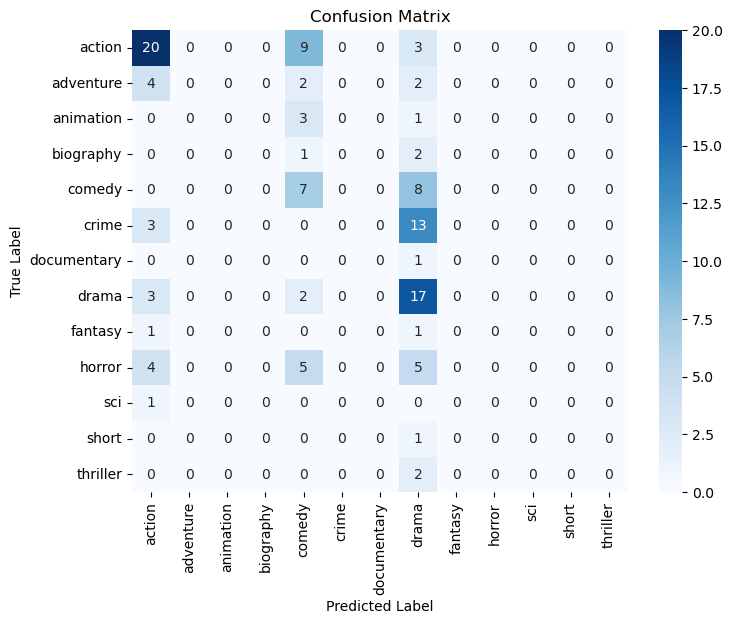

In [9]:
if __name__ == "__main__":
    ### **🔹 Convert to Hugging Face Dataset**
    hf_dataset = Dataset.from_pandas(clean_df[['text', 'label']])
    
    # Load tokenizer
    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)
    
    # Apply tokenization without `num_proc`
    tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
    print("✅ Dataset tokenized successfully!")

    # Train-test split
    split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
    train_dataset, eval_dataset = split_dataset['train'], split_dataset['test']

    ### **🔹 Load Optimized BERT Model**
    num_labels = len(genre_to_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

    ### **🔹 Define Training Arguments**
    training_args = TrainingArguments(
        output_dir="./results",       
        num_train_epochs=5,           
        per_device_train_batch_size=16,  
        per_device_eval_batch_size=16,   
        evaluation_strategy="epoch",  
        save_strategy="epoch",         
        save_total_limit=2,  
        logging_dir="./logs",         
        load_best_model_at_end=True,   
        fp16=True if device == "cuda" else False,  
        logging_steps=50,  
    )

    ### **🔹 Trainer Setup**
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
    )

    print("✅ Trainer initialized! 🚀")

    ### **🔹 Start Training**
    trainer.train()
    print("🎉 Training complete!")

    ### **🔹 Evaluate Model**
    eval_results = trainer.evaluate(eval_dataset)
    print("📊 Evaluation Results:", eval_results)

    ### **🔹 Predict & Compute Metrics**
    predictions_output = trainer.predict(eval_dataset)
    predicted_labels = np.argmax(predictions_output.predictions, axis=1)
    true_labels = np.array(eval_dataset['label'])

    # Generate classification report
    id_to_genre = {v: k for k, v in genre_to_id.items()}
    unique_ids = sorted(np.unique(true_labels))
    target_names = [id_to_genre[i] for i in unique_ids]

    print("📊 Classification Report:")
    print(classification_report(true_labels, predicted_labels, labels=unique_ids, target_names=target_names))

    ### **🔹 Confusion Matrix Visualization**
    cm = confusion_matrix(true_labels, predicted_labels, labels=unique_ids)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()